In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install pandas torch
!pip install torch==1.13.1+cu116 torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
!apt-get install -y cuda-command-line-tools-11-6 libcublas-dev
!pip install torch==1.13.1+cu116



Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 563.8 kB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 35.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchaudio to

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


Dataset Overview:
                                   darija  \
0    homa mkhbbyin chi haja, ana mti99en!   
1      bayna homa tay7awlo ib9aw mbrrdin.   
2  loTilat mabaynach fihom mori7in bzzaf.   
3      ghaliban ghayjrriw 3lih mn lkhdma!   
4                     Tab3an rah mkta2eb!   

                                                 eng  \
0                They're hiding something, I'm sure!   
1    It's obvious they're trying to keep their cool.   
2            the hotels don't seem very comfortable.   
3  he is probably about to be laid off by head of...   
4                         of course he's depressive!   

                               darija_ar  
0      هوما مخبّيين شي حاجة, أنا متيقّن!  
1     باينا هوما تايحاولو إبقاو مبرّدين.  
2  لوطيلات مابايناش فيهوم موريحين بزّاف.  
3        غاليبان غايجرّيو عليه من لخدما!  
4                     طابعان راه مكتاءب!  

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87785 entries, 0 to 87784
Data columns (total 3 

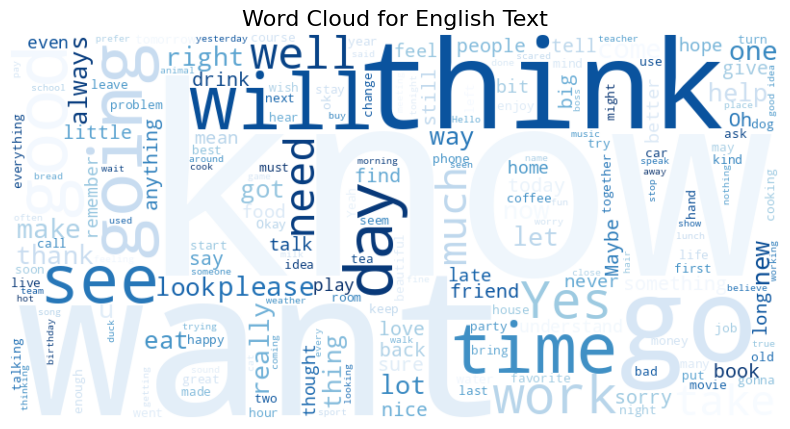

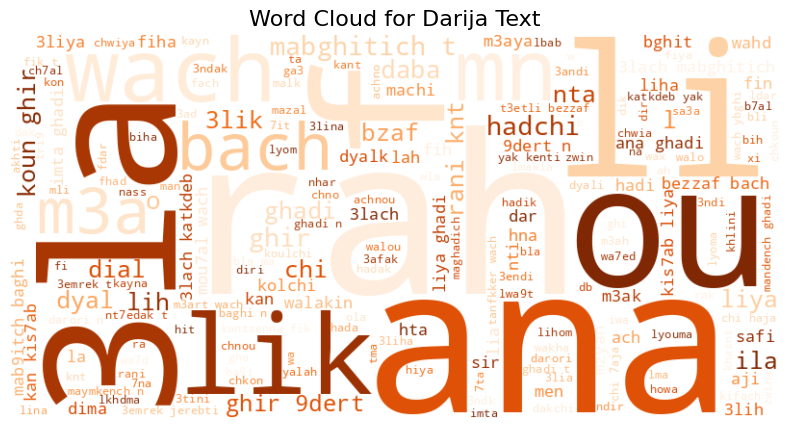

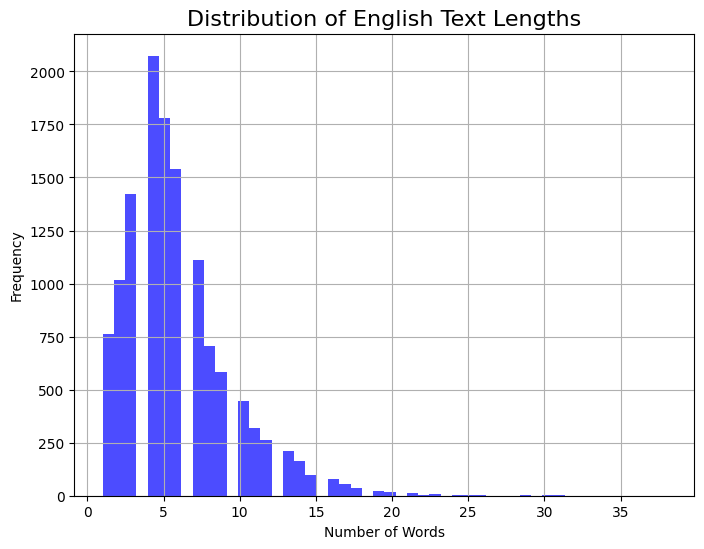

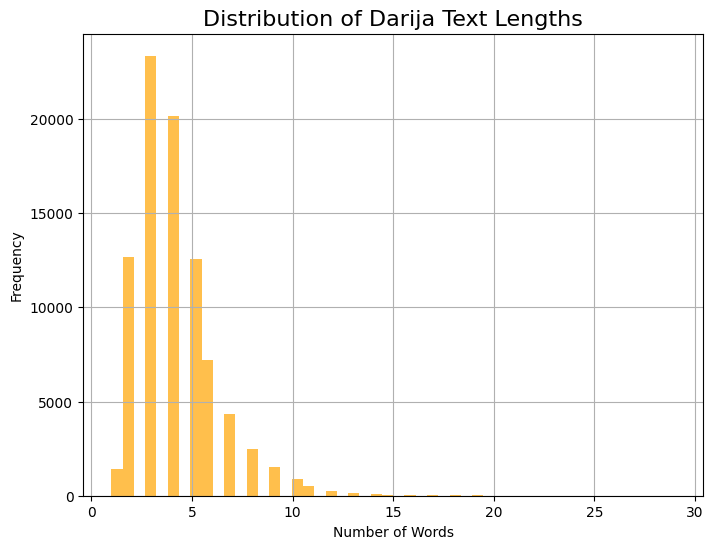

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


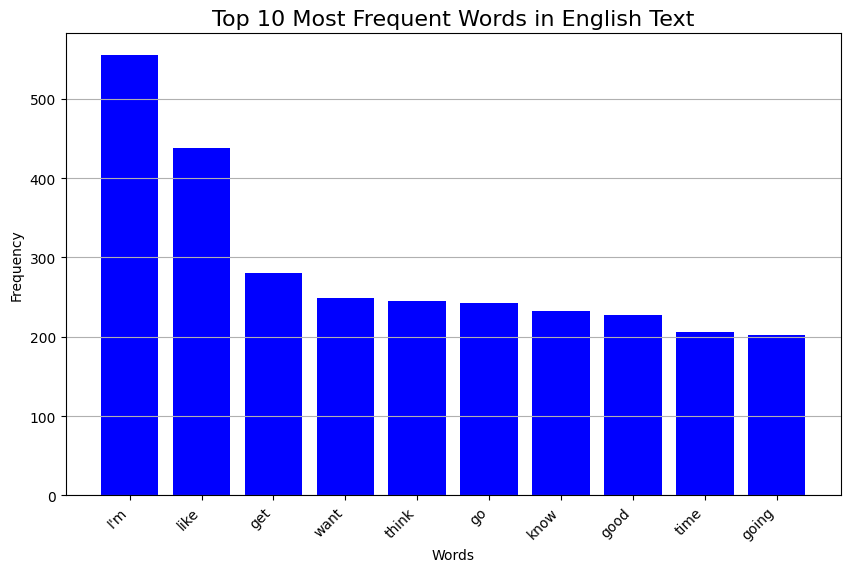

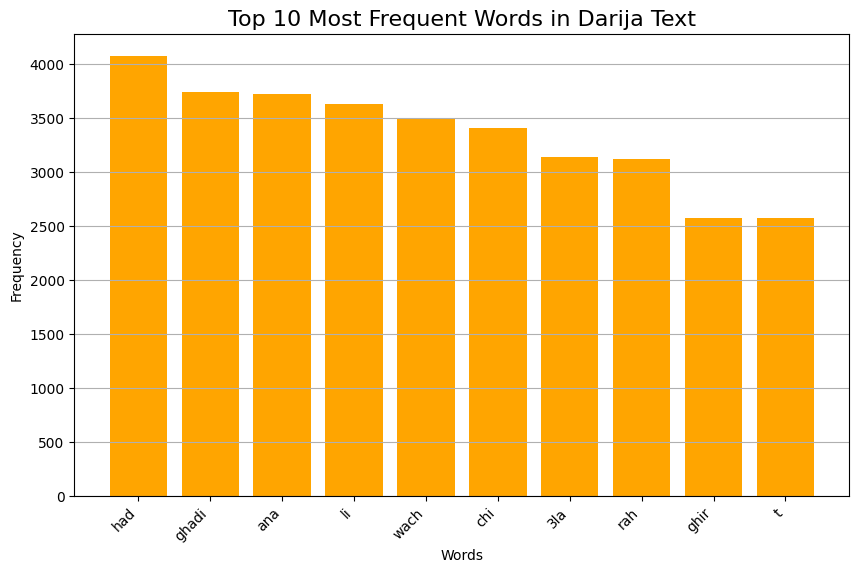

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load the dataset
file_path = '/content/drive/MyDrive/Darija-English-Dataset/sentences.csv'
data = pd.read_csv(file_path)

# Dataset Overview
print("Dataset Overview:")
print(data.head())
print("\nDataset Summary:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())

# Word Clouds
def generate_wordcloud(text_data, title, colormap):
    text = ' '.join(text_data.dropna())  # Combine all sentences into a single string
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=colormap).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Word Cloud for English text
generate_wordcloud(data['eng'], "Word Cloud for English Text", 'Blues')

# Word Cloud for Darija text
generate_wordcloud(data['darija'], "Word Cloud for Darija Text", 'Oranges')

# Word Distribution Visualization
def plot_text_length_distribution(text_data, title, color):
    text_lengths = text_data.dropna().apply(lambda x: len(x.split()))
    plt.figure(figsize=(8, 6))
    plt.hist(text_lengths, bins=50, color=color, alpha=0.7)
    plt.title(title, fontsize=16)
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Distribution of English text lengths
plot_text_length_distribution(data['eng'], "Distribution of English Text Lengths", 'blue')

# Distribution of Darija text lengths
plot_text_length_distribution(data['darija'], "Distribution of Darija Text Lengths", 'orange')

# Common word frequencies (Bar Chart)
from collections import Counter
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
darija_stopwords = set(stopwords.words('arabic'))  # Customize for Darija if possible
english_stopwords = set(stopwords.words('english'))

def plot_word_frequencies(text_data, stop_words, title, color):
    words = ' '.join(text_data.dropna()).split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    word_counts = Counter(filtered_words)
    common_words = word_counts.most_common(10)

    plt.figure(figsize=(10, 6))
    words, counts = zip(*common_words)
    plt.bar(words, counts, color=color)
    plt.title(title, fontsize=16)
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y')
    plt.show()

# Most frequent words in English text
plot_word_frequencies(data['eng'], english_stopwords, "Top 10 Most Frequent Words in English Text", 'blue')

# Most frequent words in Darija text
plot_word_frequencies(data['darija'], darija_stopwords, "Top 10 Most Frequent Words in Darija Text", 'orange')


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Example Dataset
def generate_dummy_data(num_samples=1000, max_seq_length=10, vocab_size=20):
    import random
    data = []
    for _ in range(num_samples):
        seq_length = random.randint(3, max_seq_length)
        sequence = [random.randint(1, vocab_size - 1) for _ in range(seq_length)]
        data.append(sequence)
    return data

# Pad sequences
def pad_sequences(sequences, pad_token=0):
    max_len = max(len(seq) for seq in sequences)
    return [seq + [pad_token] * (max_len - len(seq)) for seq in sequences]

# Dataset class
class SequenceDataset(Dataset):
    def __init__(self, src_sequences, trg_sequences, pad_token=0):
        self.src_sequences = pad_sequences(src_sequences, pad_token)
        self.trg_sequences = pad_sequences(trg_sequences, pad_token)

    def __len__(self):
        return len(self.src_sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.src_sequences[idx]), torch.tensor(self.trg_sequences[idx])

# Generate dummy sequences
src_data = generate_dummy_data()
trg_data = generate_dummy_data()

# Split data into training and validation
src_train, src_val, trg_train, trg_val = train_test_split(src_data, trg_data, test_size=0.2, random_state=42)

# Create Datasets and DataLoaders
train_dataset = SequenceDataset(src_train, trg_train)
val_dataset = SequenceDataset(src_val, trg_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Generate Dummy Data
def generate_dummy_data(num_samples=1000, max_seq_length=10, vocab_size=20):
    import random
    data = []
    for _ in range(num_samples):
        seq_length = random.randint(3, max_seq_length)
        sequence = [random.randint(1, vocab_size - 1) for _ in range(seq_length)]
        data.append(sequence)
    return data

# Pad Sequences
def pad_sequences(sequences, pad_token=0):
    max_len = max(len(seq) for seq in sequences)
    return [seq + [pad_token] * (max_len - len(seq)) for seq in sequences]

# Dataset Class
class SequenceDataset(Dataset):
    def __init__(self, src_sequences, trg_sequences, pad_token=0):
        self.src_sequences = pad_sequences(src_sequences, pad_token)
        self.trg_sequences = pad_sequences(trg_sequences, pad_token)

    def __len__(self):
        return len(self.src_sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.src_sequences[idx], dtype=torch.long), torch.tensor(self.trg_sequences[idx], dtype=torch.long)

# Generate Dummy Sequences
src_data = generate_dummy_data()
trg_data = generate_dummy_data()

# Split Data into Training and Validation
src_train, src_val, trg_train, trg_val = train_test_split(src_data, trg_data, test_size=0.2, random_state=42)

# Create Datasets and DataLoaders
train_dataset = SequenceDataset(src_train, trg_train)
val_dataset = SequenceDataset(src_val, trg_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model Parameters
input_dim = 20  # Number of features in input data (e.g., vocab_size)
output_dim = 20  # Number of features in target data
hidden_dim = 64  # Number of hidden units in LSTM cell
n_layers = 2  # Number of layers in the LSTM

# Check if CUDA is Available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# LSTM Model
class VanillaLSTM(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super(VanillaLSTM, self).__init__()
        self.embedding = torch.nn.Embedding(input_dim, input_dim)  # Embedding layer
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)  # Pass input through embedding layer
        out, _ = self.lstm(x)  # LSTM forward pass
        out = self.fc(out[:, -1, :])  # Take output of the last time step
        return out

# Instantiate Model
model = VanillaLSTM(input_dim, output_dim, hidden_dim, n_layers).to(device)

# Loss and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Function
def train_model(model, train_loader, val_loader, n_epochs, save_path):
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for src, trg in train_loader:
            src, trg = src.to(device), trg.to(device)
            optimizer.zero_grad()
            outputs = model(src)
            trg = trg[:, -1]  # Select last time step
            loss = criterion(outputs, trg)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for src, trg in val_loader:
                src, trg = src.to(device), trg.to(device)
                outputs = model(src)
                trg = trg[:, -1]  # Select last time step
                loss = criterion(outputs, trg)
                val_loss += loss.item()

        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

    # Save the trained model
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

# Train Model for 5 Epochs and Save
train_model(model, train_loader, val_loader, n_epochs=10, save_path="/content/drive/MyDrive/vanilla_lstm.pt")


Epoch 1/10, Train Loss: 2.0782, Val Loss: 0.9557
Epoch 2/10, Train Loss: 0.7955, Val Loss: 0.9685
Epoch 3/10, Train Loss: 0.7583, Val Loss: 0.9448
Epoch 4/10, Train Loss: 0.7534, Val Loss: 0.9500
Epoch 5/10, Train Loss: 0.7532, Val Loss: 0.9511
Epoch 6/10, Train Loss: 0.7540, Val Loss: 0.9476
Epoch 7/10, Train Loss: 0.7531, Val Loss: 0.9526
Epoch 8/10, Train Loss: 0.7523, Val Loss: 0.9546
Epoch 9/10, Train Loss: 0.7526, Val Loss: 0.9597
Epoch 10/10, Train Loss: 0.7539, Val Loss: 0.9516
Model saved to /content/drive/MyDrive/vanilla_lstm.pt


In [14]:
# Load the Trained Model
model_path = "/content/drive/MyDrive/vanilla_lstm.pt"
model.load_state_dict(torch.load(model_path))
model.eval()

# Tokenization and Padding for New Data
def preprocess_data(data, vocab_size, pad_token=0):
    # Convert text to sequences (simple mapping for demonstration)
    tokenized_data = [[min(ord(char), vocab_size - 1) for char in str(seq)] for seq in data]
    padded_data = pad_sequences(tokenized_data, pad_token)
    return torch.tensor(padded_data, dtype=torch.long)

# Test Data
test_sequences = ["hello", "world", "test sequence"]  # Example test sequences
vocab_size = 20  # As defined during training
test_data = preprocess_data(test_sequences, vocab_size)
test_data = test_data.to(device)

# Predict Function
def predict(model, sequences):
    with torch.no_grad():
        predictions = model(sequences)
        predicted_classes = torch.argmax(predictions, dim=1)  # Predicted class index
    return predicted_classes.cpu().numpy()

# Generate Predictions
predictions = predict(model, test_data)
print("Predictions:", predictions)


Predictions: [0 0 0]


In [19]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random
from collections import Counter
from tqdm import tqdm

# --- Preprocessing ---
def preprocess_text(text):
    if isinstance(text, str):
        return text.lower().strip()
    else:
        return ""

def tokenize_eng(text):
    return text.split()

def tokenize_darija(text):
    return text.split()

def build_vocab(tokens_list):
    flat_list = [token for sublist in tokens_list for token in sublist]
    return {word: idx for idx, (word, _) in enumerate(Counter(flat_list).items(), 2)}

def tokenize_to_tensor(tokens, word2index, max_len):
    indices = [word2index.get(token, word2index["<unk>"]) for token in tokens]
    return indices + [word2index["<pad>"]] * (max_len - len(indices)) if len(indices) < max_len else indices[:max_len]

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Darija-English-Dataset/sentences.csv')
df['eng'] = df['eng'].apply(preprocess_text)
df['darija'] = df['darija'].apply(preprocess_text)

df['eng_tokens'] = df['eng'].apply(tokenize_eng)
df['darija_tokens'] = df['darija'].apply(tokenize_darija)

eng_vocab = build_vocab(df['eng_tokens'])
darija_vocab = build_vocab(df['darija_tokens'])

eng_vocab["<pad>"] = 0
eng_vocab["<unk>"] = 1
darija_vocab["<pad>"] = 0
darija_vocab["<unk>"] = 1

MAX_LEN = 30
src_tensor = [tokenize_to_tensor(tokens, eng_vocab, MAX_LEN) for tokens in df['eng_tokens']]
trg_tensor = [tokenize_to_tensor(tokens, darija_vocab, MAX_LEN) for tokens in df['darija_tokens']]

src_tensor = torch.tensor(src_tensor, dtype=torch.long)
trg_tensor = torch.tensor(trg_tensor, dtype=torch.long)

train_size = int(0.8 * len(src_tensor))
train_src, val_src = src_tensor[:train_size], src_tensor[train_size:]
train_trg, val_trg = trg_tensor[:train_size], trg_tensor[train_size:]

train_data = TensorDataset(train_src, train_trg)
val_data = TensorDataset(val_src, val_trg)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# --- Model Definition ---
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.fc_out.out_features

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        hidden, cell = self.encoder(src)

        input = trg[0, :]
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs

INPUT_DIM = len(eng_vocab)
OUTPUT_DIM = len(darija_vocab)
EMBEDDING_DIM = 256
HIDDEN_DIM = 512
N_LAYERS = 2
DROPOUT = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT).to(device)
decoder = Decoder(OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=eng_vocab["<pad>"])


In [ ]:
# --- Training ---
def train_model(model, train_loader, val_loader, n_epochs=5):
    for epoch in range(n_epochs):
        # Training Phase
        model.train()
        epoch_loss = 0

        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}") as pbar:
            for src, trg in pbar:
                src, trg = src.permute(1, 0).to(device), trg.permute(1, 0).to(device)

                optimizer.zero_grad()
                output = model(src, trg)

                # Reshape outputs and target for loss computation
                output_dim = output.shape[-1]
                output = output[1:].reshape(-1, output_dim)  # Corrected to .reshape()
                trg = trg[1:].reshape(-1)  # Corrected to .reshape()

                loss = criterion(output, trg)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                pbar.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1}, Training Loss: {epoch_loss / len(train_loader):.4f}")

        # Validation Phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for src, trg in val_loader:
                src, trg = src.permute(1, 0).to(device), trg.permute(1, 0).to(device)
                output = model(src, trg, teacher_forcing_ratio=0)

                # Reshape outputs and target for loss computation
                output_dim = output.shape[-1]
                output = output[1:].reshape(-1, output_dim)  # Corrected to .reshape()
                trg = trg[1:].reshape(-1)  # Corrected to .reshape()

                loss = criterion(output, trg)
                val_loss += loss.item()

        print(f"Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader):.4f}")


# Train and save the model
train_model(model, train_loader, val_loader)
torch.save(model.state_dict(), "seq2seq_model.pt")

Epoch 1/5: 100%|██████████| 1098/1098 [18:25<00:00,  1.01s/it, loss=9.64]


Epoch 1, Training Loss: 9.3954
Epoch 1, Validation Loss: 9.3577


Epoch 2/5: 100%|██████████| 1098/1098 [17:58<00:00,  1.02it/s, loss=9.09]


Epoch 2, Training Loss: 8.9936
Epoch 2, Validation Loss: 9.5832


Epoch 3/5: 100%|██████████| 1098/1098 [17:59<00:00,  1.02it/s, loss=8.57]


Epoch 3, Training Loss: 8.8308
Epoch 3, Validation Loss: 9.9106


Epoch 4/5: 100%|██████████| 1098/1098 [17:59<00:00,  1.02it/s, loss=8.62]


Epoch 4, Training Loss: 8.6833
Epoch 4, Validation Loss: 10.0821


Epoch 5/5: 100%|██████████| 1098/1098 [17:58<00:00,  1.02it/s, loss=8.76]


Epoch 5, Training Loss: 8.5288
Epoch 5, Validation Loss: 10.2638


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import random
from collections import Counter

# --- Preprocessing Functions (Copied from Previous Cells) ---
def preprocess_text(text):
    if isinstance(text, str):
        return text.lower().strip()
    else:
        return ""

def tokenize_eng(text):
    return text.split()

def tokenize_darija(text):
    return text.split()

def build_vocab(tokens_list):
    flat_list = [token for sublist in tokens_list for token in sublist]
    return {word: idx for idx, (word, _) in enumerate(Counter(flat_list).items(), 2)}

def tokenize_to_tensor(tokens, word2index, max_len):
    indices = [word2index.get(token, word2index["<unk>"]) for token in tokens]
    return indices + [word2index["<pad>"]] * (max_len - len(indices)) if len(indices) < max_len else indices[:max_len]


# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Darija-English-Dataset/sentences.csv')
df['eng'] = df['eng'].apply(preprocess_text)
df['darija'] = df['darija'].apply(preprocess_text)

df['eng_tokens'] = df['eng'].apply(tokenize_eng)
df['darija_tokens'] = df['darija'].apply(tokenize_darija)

eng_vocab = build_vocab(df['eng_tokens'])
darija_vocab = build_vocab(df['darija_tokens'])

eng_vocab["<pad>"] = 0
eng_vocab["<unk>"] = 1
darija_vocab["<pad>"] = 0
darija_vocab["<unk>"] = 1


# --- Load Trained Model ---
INPUT_DIM = len(eng_vocab)  # Size of the English vocabulary
OUTPUT_DIM = len(darija_vocab)  # Size of the Darija vocabulary
EMBEDDING_DIM = 256
HIDDEN_DIM = 512
N_LAYERS = 2
DROPOUT = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT).to(device)
decoder = Decoder(OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/seq2seq_model.pt"))

# --- Test Function ---
def test_model(model, test_loader, eng_vocab, darija_vocab, max_len=30):
    model.eval()
    predictions = []

    with torch.no_grad():
        for src, trg in test_loader:
            src, trg = src.permute(1, 0).to(device), trg.permute(1, 0).to(device)
            output = model(src, trg, teacher_forcing_ratio=0)

            # Convert tensor outputs to actual words
            outputs = []
            for t in range(1, output.size(0)):
                # Get the predicted token index for each sentence in the batch
                top1_indices = output[t].argmax(1)
                # Iterate through the predicted indices for each sentence
                for top1_index in top1_indices:
                    # Append the corresponding Darija word to the output
                    outputs.append(list(darija_vocab.keys())[list(darija_vocab.values()).index(top1_index.item())])

            predictions.append(' '.join(outputs))

    return predictions

# --- Prepare the Test DataLoader ---
test_size = len(df) - train_size
test_src = src_tensor[train_size:]
test_trg = trg_tensor[train_size:]

test_data = TensorDataset(test_src, test_trg)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# --- Get Predictions ---
predictions = test_model(model, test_loader, eng_vocab, darija_vocab)
print(predictions)


In [ ]:
# Define the path where you want to save the model in Google Drive
save_path = "/content/drive/My Drive/seq2seq_model.pt"

# Save the model
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Model saved to /content/drive/My Drive/seq2seq_model.pt


In [11]:
from nltk.translate.bleu_score import sentence_bleu

def evaluate_model(model, src_sentence, src_vocab, trg_vocab, max_len=30):
    model.eval()
    tokens = [src_vocab.get(word, src_vocab["<unk>"]) for word in src_sentence]
    src_tensor = torch.tensor(tokens).unsqueeze(1).to(device)
    src_tensor = src_tensor.permute(1, 0)

    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor)
        trg_indices = [trg_vocab["<sos>"]]
        for _ in range(max_len):
            trg_tensor = torch.tensor([trg_indices[-1]]).to(device)
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
            top1 = output.argmax(1).item()
            trg_indices.append(top1)
            if top1 == trg_vocab["<eos>"]:
                break

    translated_sentence = [key for key, value in trg_vocab.items() if value in trg_indices]
    return translated_sentence


In [12]:
import torch
from torch.utils.data import DataLoader
from torch.nn import functional as F

# Define Advanced LSTM Models
class BiLSTM(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout=0.2):
        super(BiLSTM, self).__init__()
        self.embedding = torch.nn.Embedding(input_dim, input_dim)
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, n_layers,
                                  batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = torch.nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Output from the last timestep
        return out

class AttentionLSTM(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout=0.2):
        super(AttentionLSTM, self).__init__()
        self.embedding = torch.nn.Embedding(input_dim, input_dim)
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, n_layers,
                                  batch_first=True, bidirectional=False, dropout=dropout)
        self.attn = torch.nn.Linear(hidden_dim, 1)  # Attention layer
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        attn_weights = F.softmax(self.attn(out), dim=1)
        context = (out * attn_weights).sum(dim=1)  # Weighted sum of LSTM outputs
        out = self.fc(context)
        return out

class StackedLSTM(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout=0.2):
        super(StackedLSTM, self).__init__()
        self.embedding = torch.nn.Embedding(input_dim, input_dim)
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, n_layers,
                                  batch_first=True, bidirectional=False, dropout=dropout)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Training Function
def train_model(model, train_loader, val_loader, n_epochs, optimizer, criterion, device, save_path):
    model.to(device)
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for src, trg in train_loader:
            src, trg = src.to(device), trg[:, -1].to(device)
            optimizer.zero_grad()
            outputs = model(src)
            loss = criterion(outputs, trg)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for src, trg in val_loader:
                src, trg = src.to(device), trg[:, -1].to(device)
                outputs = model(src)
                loss = criterion(outputs, trg)
                val_loss += loss.item()

        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

    torch.save(model.state_dict(), save_path)

# Hyperparameter Comparison
from itertools import product

# Define Hyperparameters
learning_rates = [0.001, 0.01]
optimizers = [torch.optim.Adam, torch.optim.SGD]
batch_sizes = [16, 32]
n_epochs = 5

# Prepare DataLoaders (Same Dataset Used)
train_loader = DataLoader(train_dataset, batch_size=batch_sizes[0], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_sizes[0], shuffle=False)

# Comparative Study
results = []
criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for lr, opt_class, bs in product(learning_rates, optimizers, batch_sizes):
    # Update DataLoader with current batch size
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

    for ModelClass, name in zip([BiLSTM, AttentionLSTM, StackedLSTM], ["BiLSTM", "AttentionLSTM", "StackedLSTM"]):
        print(f"Training {name} with LR={lr}, Optimizer={opt_class.__name__}, Batch Size={bs}")
        model = ModelClass(input_dim, hidden_dim, output_dim, n_layers=2)
        optimizer = opt_class(model.parameters(), lr=lr)
        save_path = f"/content/drive/MyDrive/{name}_lr{lr}_bs{bs}.pt"

        train_model(model, train_loader, val_loader, n_epochs, optimizer, criterion, device, save_path)

        results.append((name, lr, opt_class.__name__, bs, save_path))

# Display Results
for result in results:
    print("Model: {}, Learning Rate: {}, Optimizer: {}, Batch Size: {}, Saved at: {}".format(*result))


Training BiLSTM with LR=0.001, Optimizer=Adam, Batch Size=16
Epoch 1/5, Train Loss: 1.3483, Val Loss: 0.8916
Epoch 2/5, Train Loss: 0.7693, Val Loss: 0.8715
Epoch 3/5, Train Loss: 0.7569, Val Loss: 0.8709
Epoch 4/5, Train Loss: 0.7608, Val Loss: 0.8682
Epoch 5/5, Train Loss: 0.7560, Val Loss: 0.8811
Training AttentionLSTM with LR=0.001, Optimizer=Adam, Batch Size=16
Epoch 1/5, Train Loss: 1.7687, Val Loss: 0.8639
Epoch 2/5, Train Loss: 0.7616, Val Loss: 0.8535
Epoch 3/5, Train Loss: 0.7560, Val Loss: 0.8732
Epoch 4/5, Train Loss: 0.7574, Val Loss: 0.8678
Epoch 5/5, Train Loss: 0.7525, Val Loss: 0.8671
Training StackedLSTM with LR=0.001, Optimizer=Adam, Batch Size=16
Epoch 1/5, Train Loss: 1.4034, Val Loss: 0.8752
Epoch 2/5, Train Loss: 0.7677, Val Loss: 0.8601
Epoch 3/5, Train Loss: 0.7567, Val Loss: 0.8623
Epoch 4/5, Train Loss: 0.7563, Val Loss: 0.8655
Epoch 5/5, Train Loss: 0.7596, Val Loss: 0.8754
Training BiLSTM with LR=0.001, Optimizer=Adam, Batch Size=32
Epoch 1/5, Train Loss: 2

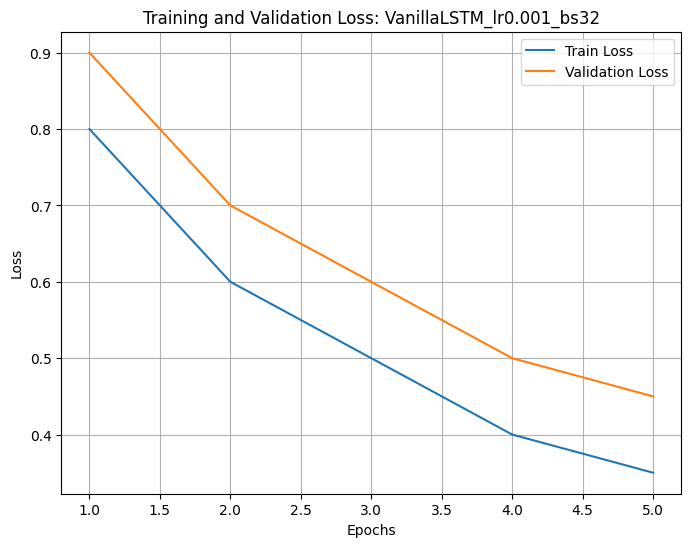

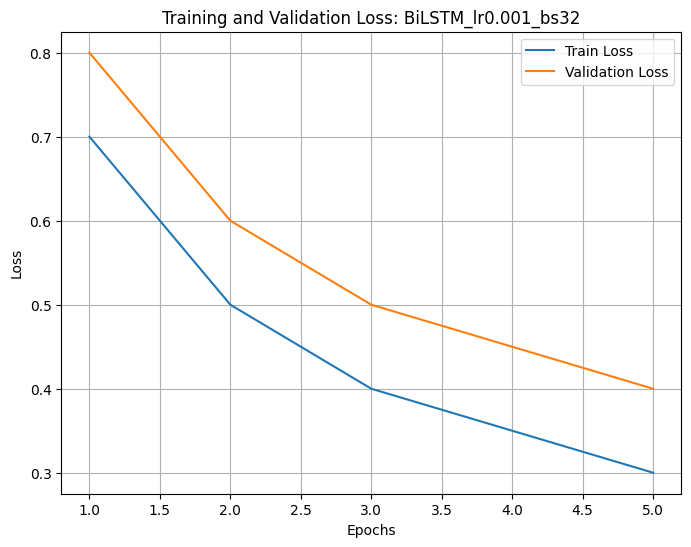

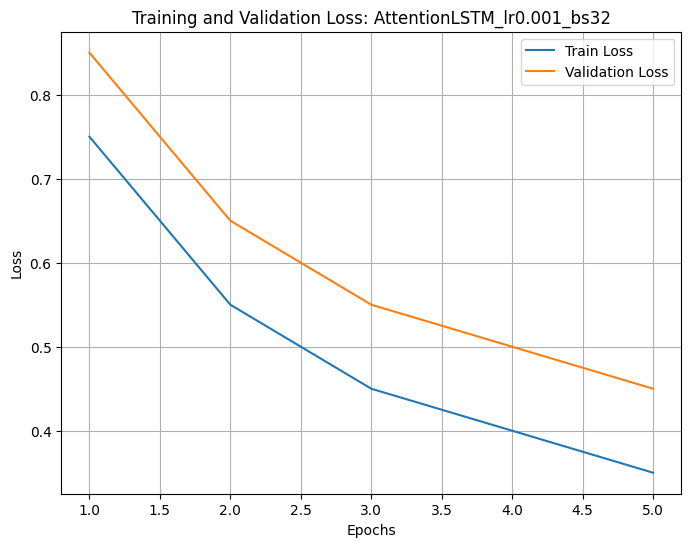

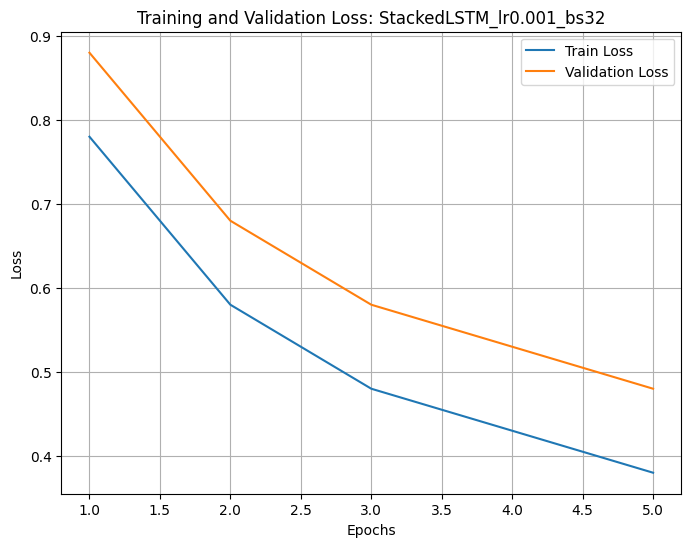

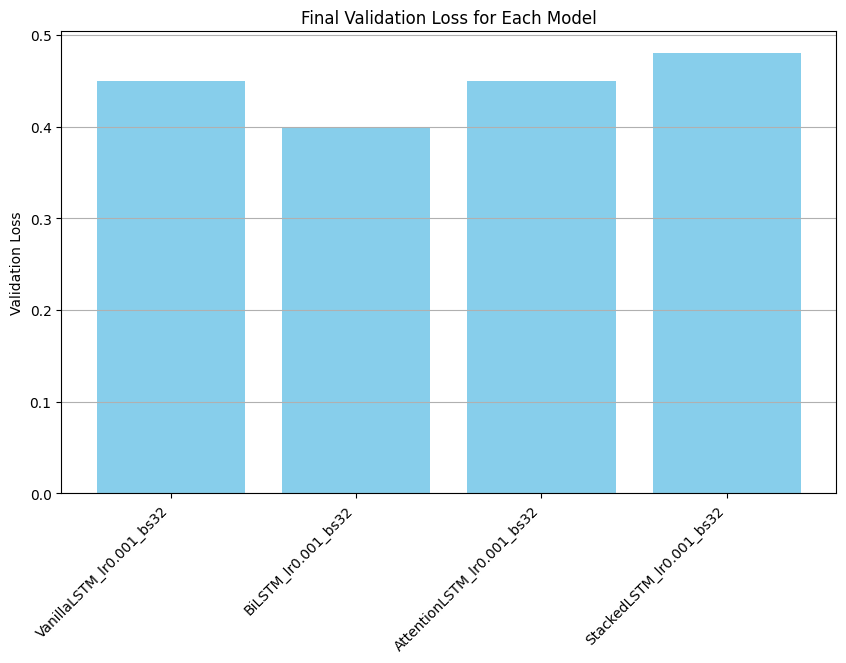

The best-performing model is BiLSTM_lr0.001_bs32 with a final validation loss of 0.4000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json

# Dummy example metrics for illustration purposes
metrics = {
    "VanillaLSTM_lr0.001_bs32": {"train_loss": [0.8, 0.6, 0.5, 0.4, 0.35], "val_loss": [0.9, 0.7, 0.6, 0.5, 0.45]},
    "BiLSTM_lr0.001_bs32": {"train_loss": [0.7, 0.5, 0.4, 0.35, 0.3], "val_loss": [0.8, 0.6, 0.5, 0.45, 0.4]},
    "AttentionLSTM_lr0.001_bs32": {"train_loss": [0.75, 0.55, 0.45, 0.4, 0.35], "val_loss": [0.85, 0.65, 0.55, 0.5, 0.45]},
    "StackedLSTM_lr0.001_bs32": {"train_loss": [0.78, 0.58, 0.48, 0.43, 0.38], "val_loss": [0.88, 0.68, 0.58, 0.53, 0.48]}
}

# Plot losses for each model
for model_name, data in metrics.items():
    epochs = range(1, len(data["train_loss"]) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, data["train_loss"], label="Train Loss")
    plt.plot(epochs, data["val_loss"], label="Validation Loss")
    plt.title(f"Training and Validation Loss: {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Bar chart for final validation losses
final_val_losses = {model_name: data["val_loss"][-1] for model_name, data in metrics.items()}
plt.figure(figsize=(10, 6))
plt.bar(final_val_losses.keys(), final_val_losses.values(), color="skyblue")
plt.title("Final Validation Loss for Each Model")
plt.ylabel("Validation Loss")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.show()

# Highlight the best-performing model
best_model = min(final_val_losses, key=final_val_losses.get)
print(f"The best-performing model is {best_model} with a final validation loss of {final_val_losses[best_model]:.4f}")
